# Preprocessing and clustering of the 3k PBMCs dataset
v2023-11-15

We gratefully acknowledge Seurat’s and Scanpy's authors for the tutorials.

We used the same data (3k PBMCs) from a Healthy Donor, which are freely available from 10x Genomics ([download page](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)). 

In [1]:
# delete the intermediate output folders to reset the tutorials
!rm -rf "data/"
!rm -rf "output/"

In [2]:
!mkdir data
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
!cd data && tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz && gzip filtered_gene_bc_matrices/hg19/* && mv filtered_gene_bc_matrices/hg19/genes.tsv.gz filtered_gene_bc_matrices/hg19/features.tsv.gz
!mkdir output

--2023-11-18 16:26:19--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.1.173, 104.18.0.173, 2606:4700::6812:ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [following]
--2023-11-18 16:26:19--  https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7.3M) [application/x-tar]
Saving to: ‘data/pbmc3k_filtered_gene_bc_matrices.tar.gz’

data/pbmc3k_filtere 100%[===================>]   7.27M  2.75MB/s    in 2.6s    

2023-11-18 16:26:23 (2.75 MB/s) - ‘data/pbmc3k_filtered_gene_bc_matric

In [3]:
# not use GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# import scelephant
import scelephant as el
from scelephant import RamData
import scanpy as sc

# plotly export settings
import plotly.io as pio
pio.renderers.default = "notebook"

"""
configure the jupyter notebook environment
"""
el.bk.Wide( 100 ) # adjust the jupyter notebook cell width 

import matplotlib as mpl
mpl.rcParams[ "figure.dpi" ] = 100
# set image resolution

# load memory profiler 
# %load_ext memory_profiler

## **Convert MTX -> RamData**

In [4]:
# initialize a pool of managed operators
fop = el.managers.FileSystemOperatorPool( 8 ) # this pool of managed operators will be used throughout the tutorials

# create RamData from 10X-formateed MTX
el.create_ramdata_from_mtx( 
    path_folder_mtx_10x_input = f'data/filtered_gene_bc_matrices/hg19/', 
    path_folder_ramdata_output = f'output/pbmc3k.ram/',
    file_system_operator_pool = fop,
)

## **loading RamData**

In [5]:
ram = RamData( 
    f'output/pbmc3k.ram/', 
    int_total_weight_for_each_batch = 100_000,
    int_num_cpus = 8,
    file_system_operator_pool = fop
)

2023-11-18 16:26:39,413 [SC-Elephant] <INFO> (layer) - 'raw' layer has been loaded


## **view RamData**
- JavaScript-based interactive visualization of RamData object in Jupyter Notebook

In [6]:
ram

<RamData object (2700 barcodes X 32738 features, 2286884 records in the currently active layer 'raw') stored at /home/merit_an/git/scelephant/doc/jn/tutorials/output/pbmc3k.ram/
	with the following layers : {'raw'}
		current layer is 'raw'>

## **preprocessing**

2023-11-18 16:26:42,318 [SC-Elephant] <INFO> (prepare_dimension_reduction_from_raw) - [SLOW MODE] converting dense to sparse formats ... 
2023-11-18 16:26:42,367 [aiobotocore.credentials] <INFO> (load) - Found credentials in shared credentials file: ~/.aws/credentials
raw/dense > raw/sparse_for_querying_features: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2286884.0/2286884 [00:01<00:00, 1885673.73it/s]
raw/dense > raw/sparse_for_querying_barcodes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

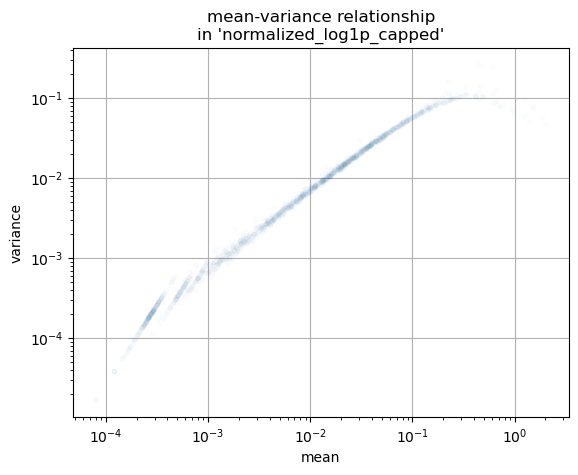

In [7]:
# analysis using fast mode
flag_use_fast_mode = False # does not generate intermediate output layers for fast analysis # you can set the flag to False to generate all intermediate layers
# preprocess outputs
ram.prepare_dimension_reduction_from_raw( 
    name_layer_raw = 'raw', # name of the input layer
    name_layer_capped = 'normalized_log1p_capped', # name of the output layer for dimension reduction
    name_layer_scaled = None, # does not perform scaling (capping is often sufficient)
    name_col_filter_filtered_barcode = 'filtered_barcodes', # the name of the 'barcode' axis filter that will contain filtered cells
    min_counts = 500, # cell filtering criteria
    min_features = 200, 
    int_total_count_target = 10_000, # target count for normalization
    int_num_highly_variable_features = 2_000, # the number of the highly-variable features for performing dimension reduction
    name_col_filter_highly_variable = 'filter_normalized_log1p_highly_variable_2000', # the name of the 'feature' axis filter that will contain detected highly variable features
    max_value = 10, 
    dict_kw_hv = { 'float_min_mean' : 0.01, 'float_min_variance' : 0.01 }, 
    flag_use_fast_mode = flag_use_fast_mode,
)

## **perform dimension reduction and clustering**

2023-11-18 16:27:42,743 [SC-Elephant] <WARNING> (train_pca) - iPCA model 'ipca' does not exist in the RamData models database, initializing the model.
30 PCs from 1999 features: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2700/2700 [00:19<00:00, 137.73it/s]
2023-11-18 16:28:03,723 [SC-Elephant] <INFO> (train_pca) - fit completed
2023-11-18 16:28:03,765 [SC-Elephant] <INFO> (load_str) - completed loading of 1999 number of strings
2023-11-18 16:28:03,791 [SC-Elephant] <INFO> (load_str) - completed loading of 1999 number of strings
2023-11-18 16:28:04,123 [SC-Elephant] <INFO> (save_model) - ipca|ipca model saved.
30 PCs from 1999 features: 100%|███████████████████████████████

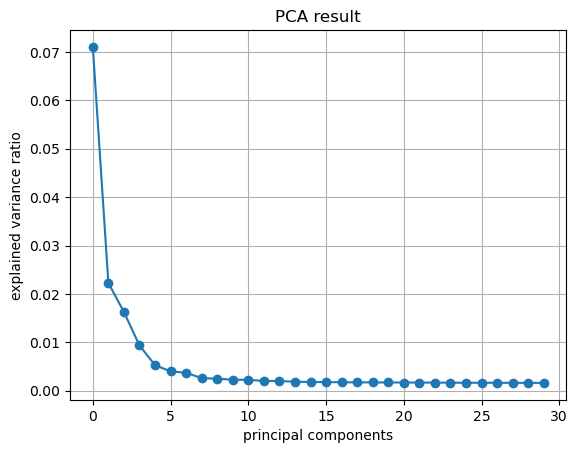

In [8]:
# perform UMAP embedding
ram.perform_dimension_reduction_and_clustering(
    name_layer_pca = 'normalized_log1p_capped', 
    name_filter_barcodes = 'filtered_barcodes',
    name_filter_features = 'filter_normalized_log1p_highly_variable_2000',
    str_embedding_method = 'scanpy-umap', # use scanpy functions to generate umap and leiden clustering results
    float_prop_subsampling_pca = 1, # use all cells without subsampling (TIP: for large dataset, it is recommended to use number below 0.5 to reduce PCA fitting time)
    dict_kw_for_run_scanpy_using_pca = {
        'int_neighbors_n_neighbors': 30, 
        'int_neighbors_n_pcs': 30, 
        'set_method': {'umap', 'leiden'}, # run umap and leiden 
        'dict_kw_leiden': {'resolution': 0.5}, 
    },
)

## **perform dimension reduction and clustering**

In [31]:
ram.bc.columns

{'X_pca',
 'X_umap_scanpy',
 'filter_pca',
 'filtered_barcodes',
 'leiden_scanpy',
 'raw_mean',
 'raw_num_nonzero_values',
 'raw_sum'}

2023-11-18 17:11:41,809 [SC-Elephant] <INFO> (load_str) - completed loading of 2700 number of strings
2023-11-18 17:11:41,877 [SC-Elephant] <INFO> (load_str) - completed loading of 32738 number of strings


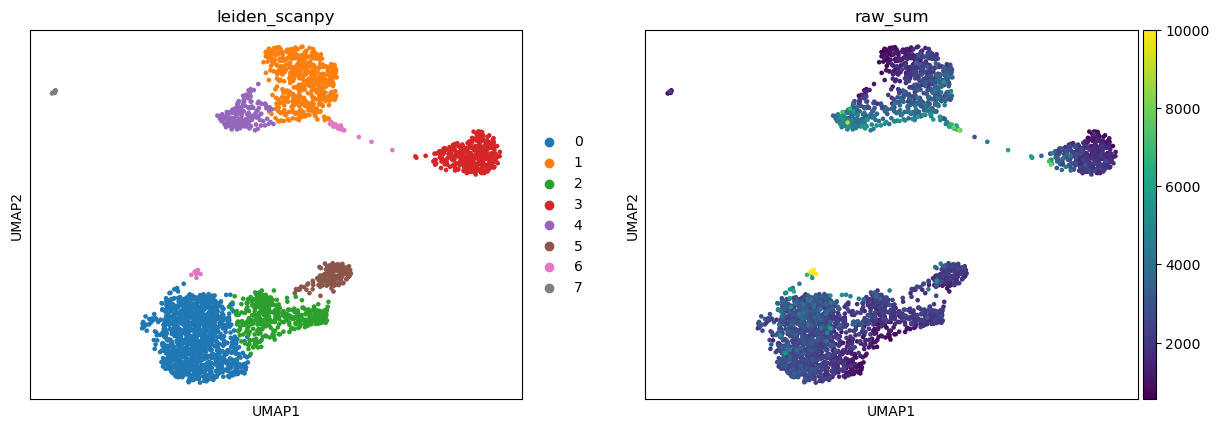

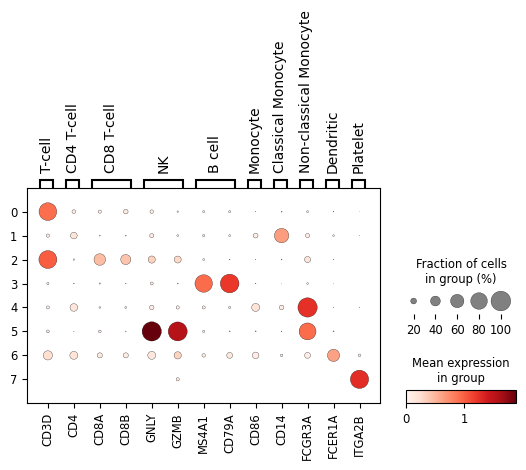

In [38]:
"""
Display UMAP clustering results with marker genes
"""
# settings
name_col_label = 'leiden_scanpy'
name_col_umap = 'X_umap_scanpy'
dict_marker_genes = {
    'T-cell' : [ 'CD3D' ],
    'CD4 T-cell' : [ 'CD4' ],
    'CD8 T-cell' : [ 'CD8A', 'CD8B' ],
    'NK' : [ 'GNLY', 'GZMB' ],
    'B cell' : [ 'MS4A1', 'CD79A' ], 
    'Monocyte' : [ 'CD86' ],
    'Classical Monocyte' : [ 'CD14' ], 
    'Non-classical Monocyte' : [ 'FCGR3A' ],
    'Dendritic' : [ 'FCER1A' ],
    'Platelet' : [ 'ITGA2B' ],
}
# dict_marker_genes = {
#     'Proliferating' : [ 'MKI67' ],
#     'T-cell' : [ 'CD3D' ],
#     'CD4 T-cell' : [ 'CD4' ],
#     'CD8 T-cell' : [ 'CD8A', 'CD8B' ],
#     'Naive T / TCM' : [ 'CCR7', 'SELL' ],
#     'Effector Phenotype' : [ 'FAS', 'CD44', 'IL2RG', 'IL7R', 'CD69' ],
#     'TREG' : [ 'FOXP3', 'IL2RA' ], # , 'TNFRSF4'
#     'MAIT' : [ 'KLRB1', 'SLC4A10' ], # 'TRAJ33', 'TRAJ12', 'TRAJ20',  'CXCR6', 'TRAV1-2'
#     'SOX4+ CD4 T' : [ 'SOX4' ], # 'ID2'
#     'NK' : [ 'GNLY', 'GZMB' ],
#     'NK Recruiting (CD56 bright)' : [ 'XCL1', 'GZMK' ], 
#     'B cell' : [ 'MS4A1', 'CD79A' ], # 'CD19',  
#     'B memory' : [ 'CD27' ],
#     'Plasma cell' : [ 'TXNDC5' ],
#     'Monocyte' : [ 'CD86' ],
#     'Classical Monocyte' : [ 'CD14' ], # 'LYZ'
#     'Non-classical Monocyte' : [ 'FCGR3A' ],
#     'Macrophage' : [ 'CD68' ],
#     'Macrophage (M1)' : [ 'CD86', 'FCGR2A', ], #  'CD80'
#     'Macrophage (M2)' : [ 'CD163', 'MSR1' ], # 'MRC1'
#     'Dendritic' : [ 'FCER1A' ],
#     "cDC1" : [ 'THBD', 'CLEC9A' ], # 'XCR1'
#     'cDC2' : [ 'CD1C', 'SIRPA' ], # 'ITGAM'
#     'pDC' : [ 'CLEC4C', 'IL3RA', 'LILRA4' ], # 'NRP1'
#     'Platelet' : [ 'ITGA2B' ],
#     'HPSC' : [ 'CD34' ],
# }

def Get_AnnData_from_RamData( l_name_gene : list, l_name_obs : list = [ ] ) :
    ''' # 2023-11-18 16:57:29 
    Load data from RamData in the AnnData format.
    '''
    # retrieve data in SCANPY's AnnData format
    ram.ft.filter = None # reset the filter
    adata = ram[
        'normalized_log1p_capped', # [layer selection] name of the layer
        :, # [barcode selection] all active cells (barcodes) in the filter
        [ # [barcode metadata selection] e.g., annotations, barcode names, and PCA/UMAP coordinates
            'str', # 'str' meaning string representations of the cells (barcodes)
            'raw_sum', # 'n_Counts' (total number of UMIs)
            name_col_label, # clustering results
            { 'X_pca', name_col_umap } # 2D data (values stored commonly in '.obsm') should be given as a set (or dictionary, in order to specify the number of dimensions to retrieve. by default, retrieve all dimensions)
        ] + l_name_obs, 
        l_name_gene, # [feature selection] specific features
        [ 'str' ] # [feature metadata] name of the features
    ]
    adata.obsm[ 'X_umap' ] = adata.obsm[ name_col_umap ] # copy UMAP coordinates for plotting
    return adata

# retrieve AnnData containing normalized gene expression counts of a given marker genes
l_marker_genes = [ ]
for e in dict_marker_genes :
    l_marker_genes += dict_marker_genes[ e ]
adata = Get_AnnData_from_RamData( l_marker_genes )

# plot leiden clustering result
sc.pl.umap( adata, color = ['leiden_scanpy', 'raw_sum'], vmax = 10000 )

# show dotplot
sc.pl.dotplot( adata, dict_marker_genes, groupby = name_col_label )

In [ ]:

# plot gene expression values
sc.pl.umap( adata, color = l_marker_genes, cmap = 'Reds', ncols = 2 )


In [ ]:
adata

## **Search marker genes and annotate clusters**

SC-Elephant enables  memory-efficient marker gene search by loading expression values of each gene separately and perform several tests.
Currently, SC-Elephant supports following tests:
- Log2 Fold Change difference (cell type vs. rest)
- AUROC (area under receiver operating characteristic curve) - measures how the current gene can classify the current cell type from the rest of the cells in the dataset
- T-test (or Wilcoxon rank sum test )

In [12]:
"""
Find marker genes of each cluster
"""
# settings
flag_perform_subsampling = False # it is highly recommended to turn on cluster-based subsampling for an extremely large dataset!
name_layer = 'normalized_log1p_capped'

if flag_perform_subsampling :
    ''' subsample for each cluster using the label '''
    ram.subsample_for_each_clus( 
        name_col_label = name_col_label, 
        int_num_entries_to_subsample = int( len( ram.bc ) / 3 ),  # subsample 1/3 of cells
        index_col_of_name_col_label = -1,
        name_col_filter = 'filtered_barcodes', # input column name containing the filter to subsample
        name_col_filter_subsampled = None, # output column name to store the filter. If None is given, output to current filter object
    )

''' search marker feature for each cluster '''
ram.find_markers( 
    name_layer = name_layer, # normalized using log1p-normalized values
    name_col_label = name_col_label, # name of the annotation column to perform marker gene search
    index_name_col_label = -1, # for a typical annotation column containing 1D data array, set this value to -1 (indicating 1D)
    l_name_cluster = None, # search marker genes for all cluster labels
    name_col_log2fc = f'{name_col_label}__marker_log2fc', 
    name_col_auroc = f'{name_col_label}__marker_auroc', 
    name_col_pval = f'{name_col_label}__marker_pval', 
    method_pval = 'wilcoxon', # use wilcoxon test 
)

''' retrieve filtered marker calculation results '''
df_res = ram.get_marker_table( 
    max_pval = 1e-3, 
    min_auroc = 0.6, 
    min_log2fc = 1, 
    name_col_log2fc = f'{name_layer}_{name_col_label}__marker_log2fc', 
    name_col_auroc = f'{name_layer}_{name_col_label}__marker_auroc', 
    name_col_pval = f'{name_layer}_{name_col_label}__marker_pval', 
)
df_res # display marker gene search results



2023-11-18 16:39:12,879 [SC-Elephant] <INFO> (find_markers) - [RamData.find_markers] finding markers for 8 number of clusters started
normalized_log1p_capped / features: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2286884.0/2286884 [01:04<00:00, 35603.67it/s]
2023-11-18 16:40:17,608 [SC-Elephant] <INFO> (summarize) - summarize operation of normalized_log1p_capped in the 'feature' axis was completed
2023-11-18 16:40:17,610 [SC-Elephant] <INFO> (find_markers) - finding markers for 8 number of clusters completed


In [24]:
''' select the best marker genes for each cluster '''
import pandas as pd
# settings 
int_num_marker_genes_to_retrieve_for_each_cluster = 5
df_res_best = pd.concat( list( _df.sort_values( 'value_auroc', ascending = False ).iloc[ : int_num_marker_genes_to_retrieve_for_each_cluster ] for name_clus, _df in df_res.groupby( 'name_cluster' ) ) )
df_res_best # display results

,name_feature,name_cluster,value_auroc,value_log2fc,value_pval
625,LDHB,0,0.859696,1.326176,1.947799e-223
604,CD3D,0,0.804716,1.716893,6.150832e-161
290,LTB,0,0.774523,1.048125,5.276650e-131
603,CD3E,0,0.757246,1.545974,2.826067e-115
242,IL7R,0,0.735870,1.748219,3.181737e-97
638,LYZ,1,0.995599,2.195577,7.987939e-264
59,S100A9,1,0.991504,3.438588,1.618067e-259
61,S100A8,1,0.976530,4.182242,4.495842e-244
916,TYROBP,1,0.964816,2.506177,2.520615e-232
836,CST3,1,0.956059,2.597042,9.852227e-224


In [ ]:
df_res_best.name_feature

In [22]:
df_

,name_feature,name_cluster,value_auroc,value_log2fc,value_pval
625,LDHB,0,0.859696,1.326176,1.947799e-223
604,CD3D,0,0.804716,1.716893,6.150832e-161
290,LTB,0,0.774523,1.048125,5.276650e-131
603,CD3E,0,0.757246,1.545974,2.826067e-115
242,IL7R,0,0.735870,1.748219,3.181737e-97
638,LYZ,1,0.995599,2.195577,7.987939e-264
59,S100A9,1,0.991504,3.438588,1.618067e-259
61,S100A8,1,0.976530,4.182242,4.495842e-244
916,TYROBP,1,0.964816,2.506177,2.520615e-232
836,CST3,1,0.956059,2.597042,9.852227e-224


In [15]:
df_res.sort_values( 'value_auroc' )

,name_feature,name_cluster,value_auroc,value_log2fc,value_pval
512,TSPAN14,4,0.600270,1.409924,1.542991e-05
217,OCIAD2,0,0.600548,1.293840,4.663702e-19
449,SDCBP,1,0.600626,1.020177,1.849874e-12
163,RAMP1,5,0.600689,5.923278,2.357984e-05
72,FCRL6,5,0.600692,3.257715,2.356876e-05
...,...,...,...,...,...
151,SDPR,7,0.999966,7.731325,9.960512e-09
222,PF4,7,1.000000,7.782297,9.937774e-09
223,PPBP,7,1.000000,7.017707,9.937774e-09
266,SPARC,7,1.000000,7.783925,9.937774e-09
